# XOR Multiple Inputs/Targets

This notebook explores networks with multiple input and output banks.

In [1]:
import conx as cx

Using TensorFlow backend.
ConX, version 3.7.5


In [2]:
net = cx.Network("XOR Network", 2, 3, 1, activation="sigmoid")

In [3]:
net.compile(loss='mean_squared_error', optimizer='sgd', lr=0.3, momentum=0.9)

In [4]:
XOR = [
    ([0, 0], [0], "0"),
    ([0, 1], [1], "1"),
    ([1, 0], [1], "1"),
    ([1, 1], [0], "0")
]

In [5]:
net.dataset.load(XOR)
net.dataset.summary()

_________________________________________________________________
XOR Network Dataset:
Patterns    Shape                 Range                         
inputs      (2,)                  (0.0, 1.0)                    
targets     (1,)                  (0.0, 1.0)                    
Total patterns: 4
   Training patterns: 4
   Testing patterns: 0
_________________________________________________________________


In [6]:
dash = net.dashboard()
dash

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, …

In [7]:
net.propagate([0, 1])

[0.4066244959831238]

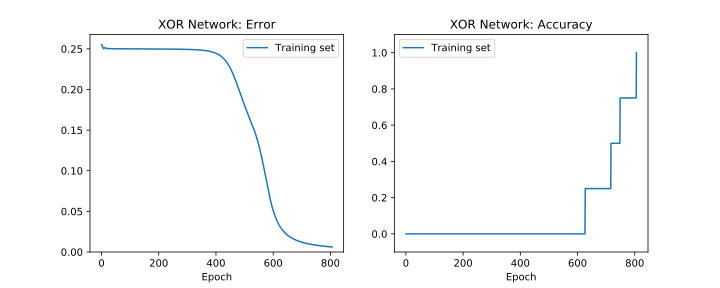

       |  Training |  Training 
Epochs |     Error |  Accuracy 
------ | --------- | --------- 
#  806 |   0.00616 |   1.00000 


In [8]:
net.train(epochs=1000, accuracy=1, report_rate=25, record=True)

SequenceViewer(children=(VBox(children=(HBox(children=(IntSlider(value=0, continuous_update=False, description…

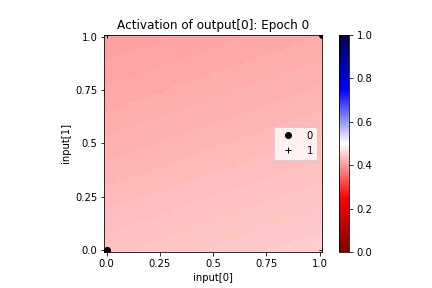

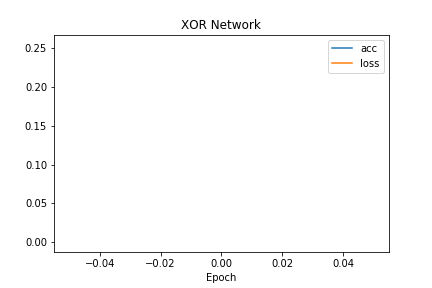

In [9]:
zeros = net.dataset.inputs.select(lambda i,ds: ds.labels[i] == "0")
ones = net.dataset.inputs.select(lambda i,ds: ds.labels[i] == "1")

net.playback(lambda net,epoch: (
    net.plot_activation_map(scatter=[["0", zeros], ["1", ones]],
                            symbols={"0": "ko", "1": "k+"},
                            title="Epoch %s" % epoch,
                            format="image"),
    net.plot('all', end=epoch+1, format="image")))

We need to remember to reset the network's weights to the last epoch of training, so that subsequent interactions with the network reflect its learned knowledge.

In [10]:
net.set_weights_from_history(-1)

In [11]:
states = [net.propagate_to("hidden", pattern) for pattern in net.dataset.inputs]
pca = cx.PCA(states)

SequenceViewer(children=(VBox(children=(HBox(children=(IntSlider(value=0, continuous_update=False, description…

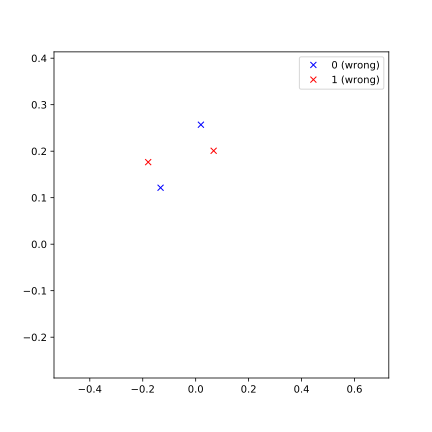

In [12]:
symbols = {
    "0 (correct)": "bo",
    "0 (wrong)": "bx",
    "1 (correct)": "ro",
    "1 (wrong)": "rx",
}
net.playback(lambda net,epoch: cx.scatter(**pca.transform_network_bank(net, "hidden"),
                                          symbols=symbols,
                                          format='svg'))

In [13]:
net.set_weights_from_history(-1)

In [14]:
net.propagate_to("input", [0, 1])

[0.0, 1.0]

In [15]:
net.propagate([0.5, 0.5])

[0.1825655698776245]

In [16]:
net.propagate_to("hidden", [1, 0])

[0.07512849569320679, 0.9955328702926636, 0.9639556407928467]

In [17]:
net.propagate_to("output", [1, 1])

[0.09972702711820602]

In [18]:
net.propagate_to("input", [0.25, 0.25])

[0.25, 0.25]

In [19]:
net.propagate_from("input", [1.0, 1.0])

[0.09972702711820602]

In [20]:
net.propagate_from("hidden", [1.0, 0.0, -1.0])

[8.784712554188445e-05]

In [21]:
net2 = cx.Network("XOR2 Network")

net2.add(cx.Layer("input1", 1),
         cx.Layer("input2", 1),
         cx.Layer("hidden1", 10, activation="sigmoid"),
         cx.Layer("hidden2", 10, activation="sigmoid"),
         cx.Layer("shared-hidden", 5, activation="sigmoid"),
         cx.Layer("output1", 1, activation="sigmoid"),
         cx.Layer("output2", 1, activation="sigmoid"))

net2.connect("input1", "hidden1")
net2.connect("input2", "hidden2")
net2.connect("hidden1", "shared-hidden")
net2.connect("hidden2", "shared-hidden")
net2.connect("shared-hidden", "output1")
net2.connect("shared-hidden", "output2")


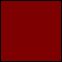
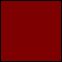
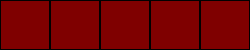
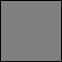
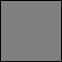

In [22]:
net2.picture()

In [23]:
net2.layers[2].incoming_connections

[<Layer name='input1', shape=(1,), act='None'>]

In [24]:
net2.compile(loss='mean_squared_error', optimizer='SGD', lr=0.3, momentum=0.9)

In [25]:
net2.config["hspace"] = 200
dash = net2.dashboard()
dash

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, …

In [26]:
net2.propagate_to("hidden1", [[1], [1]])

[0.541100800037384,
 0.3278562128543854,
 0.3921108841896057,
 0.42058151960372925,
 0.41650843620300293,
 0.4361613690853119,
 0.36962926387786865,
 0.4186179041862488,
 0.44622373580932617,
 0.5558428764343262]

In [27]:
net2.propagate([[1], [1]])

[[0.5255315899848938], [0.24715031683444977]]

In [28]:
XOR2 = [
    ([[0],[0]], [[0],[0]]),
    ([[0],[1]], [[1],[1]]),
    ([[1],[0]], [[1],[1]]),
    ([[1],[1]], [[0],[0]])
]

In [29]:
net2.dataset.load(XOR2)

In [30]:
net2.get_weights("hidden2")

[[[-0.6272611618041992,
   0.3946005702018738,
   0.6141403317451477,
   0.6681897044181824,
   -0.4868648052215576,
   -0.5547021627426147,
   0.1374884843826294,
   -0.22490054368972778,
   -0.12803512811660767,
   -0.7175639867782593]],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

In [31]:
net2.propagate([[1], [1]])

[[0.5255315899848938], [0.24715031683444977]]

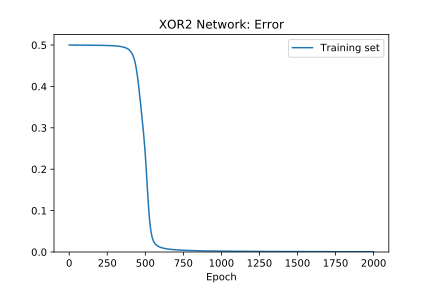

In [32]:
import time
net2.reset()
for i in range(20):
    (epoch_count, results) = net2.train(epochs=100, verbose=0, report_rate=25)
    for index in range(4):
        net2.propagate(XOR2[index][0])
        time.sleep(0.1)

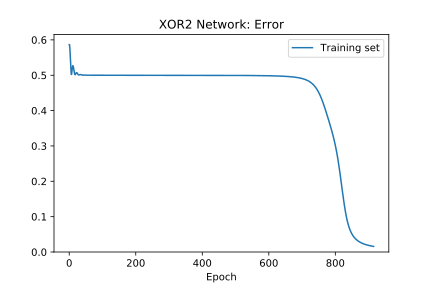

       |  Training |   output1 |   output2 
Epochs |     Error |       acc |       acc 
------ | --------- | --------- | --------- 
#  915 |   0.01573 |   1.00000 |   1.00000 


In [33]:
net2.reset()
net2.train(epochs=2000, accuracy=1.0, report_rate=25)

In [33]:
net2.propagate_from("shared-hidden", [0.0] * 5)

[[0.6343947649002075], [0.5863332]]

In [34]:
net2.propagate_to("hidden1", [[1], [1]])

[0.11640828102827072,
 0.8285501003265381,
 0.8238552808761597,
 0.7559378743171692,
 0.7736209034919739,
 0.7370111346244812,
 0.8081612586975098,
 0.27545997500419617,
 0.8407012820243835,
 0.20506168901920319]

In [35]:
net2.dataset.slice(2)

In [36]:
net2.train(epochs=2000, accuracy=1.0, report_rate=25)

No training required: accuracy already to desired value
Training dataset status:
       |  Training |   output1 |   output2 
Epochs |     Error |       acc |       acc 
------ | --------- | --------- | --------- 
# 2000 |   0.00066 |   1.00000 |   1.00000 


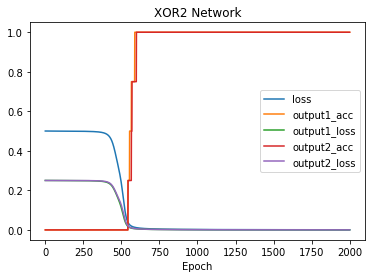

In [37]:
net2.plot('all')